<a href="https://colab.research.google.com/github/marclamberts/football-analysis/blob/main/Expected_Cross_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# --- Import Libraries ---
import pandas as pd
import numpy as np
from tqdm import tqdm

# --- Load Data ---
file_path = '/content/drive/MyDrive/Recruitment/Brøndby 1-1 Nordsjælland.csv'  # Change if needed
df = pd.read_csv(file_path)

# Add event time
df['eventTime'] = df['timeMin'] * 60 + df['timeSec']

# --- Step 1: Identify Passes and Crosses ---
passes = df[df['typeId'] == 1].copy()

def has_qualifier(row, q_id):
    for i in range(20):
        q_col = f'qualifier/{i}/qualifierId'
        if q_col in row and row[q_col] == q_id:
            return True
    return False

def get_qualifier_value(row, q_id):
    for i in range(20):
        q_id_col = f'qualifier/{i}/qualifierId'
        q_val_col = f'qualifier/{i}/value'
        if q_id_col in row and row[q_id_col] == q_id:
            return float(row[q_val_col]) if pd.notnull(row[q_val_col]) else None
    return None

# Label crosses, assists, key passes
passes['isCross'] = passes.apply(lambda r: has_qualifier(r, 2), axis=1)
passes['endX'] = passes.apply(lambda r: get_qualifier_value(r, 140), axis=1)
passes['endY'] = passes.apply(lambda r: get_qualifier_value(r, 141), axis=1)
passes['isAssist'] = passes.apply(lambda r: has_qualifier(r, 210), axis=1)
passes['isSecondAssist'] = passes.apply(lambda r: has_qualifier(r, 218), axis=1)

# Key pass detection
shots = df[df['typeId'].isin([13, 14, 15, 16])].copy()
shots['eventTime'] = shots['timeMin'] * 60 + shots['timeSec']

def find_key_pass(row):
    future = shots[(shots['periodId'] == row['periodId']) & (shots['eventTime'] > row['eventTime'])]
    if not future.empty:
        return future.iloc[0]['typeId']
    return None

passes['linkedShotTypeId'] = passes.apply(find_key_pass, axis=1)
passes['isKeyPass'] = passes['linkedShotTypeId'].isin([13, 14, 15])

# --- Step 2: Filter Crosses ---
crosses = passes[passes['isCross']].copy()

# Merge outcome and time data safely
for col in ['outcome', 'periodId', 'timeMin', 'timeSec']:
    if col in crosses.columns:
        crosses = crosses.drop(columns=[col])
crosses = crosses.merge(
    passes[['id', 'outcome', 'periodId', 'timeMin', 'timeSec']],
    on='id', how='left'
)
crosses['outcome'] = pd.to_numeric(crosses['outcome'], errors='coerce').fillna(0).astype(int)

# --- Step 3: Geometry-Based xC ---
GOAL_X, GOAL_Y, GOAL_WIDTH = 100, 50, 7.32
MAX_DIST = np.sqrt(100**2 + 50**2)

def calculate_distance(x, y):
    return np.sqrt((GOAL_X - x)**2 + (GOAL_Y - y)**2)

def calculate_angle(x, y):
    b = GOAL_X - x
    if b <= 0:
        return 0
    angle = np.arctan((GOAL_WIDTH * 0.5) / b)
    return angle * 2

crosses['distanceToGoal'] = crosses.apply(lambda r: calculate_distance(r['endX'], r['endY']), axis=1)
crosses['angleToGoal'] = crosses.apply(lambda r: calculate_angle(r['endX'], r['endY']), axis=1)
crosses['angleScore'] = crosses['angleToGoal'] / np.pi
crosses['distanceScore'] = 1 - (crosses['distanceToGoal'] / MAX_DIST)
crosses['eventBonus'] = 0
crosses.loc[crosses['isKeyPass'], 'eventBonus'] += 0.15
crosses.loc[crosses['isAssist'], 'eventBonus'] += 0.30
crosses['successBonus'] = crosses['outcome'].apply(lambda x: 0.2 if x == 1 else 0)

# Zone/Depth Features
def cross_zone(x, y):
    if y < 33: return 'Right Wing'
    elif y > 67: return 'Left Wing'
    return 'Central'

crosses['crossZone'] = crosses.apply(lambda r: cross_zone(r['x'], r['y']), axis=1)
crosses['deepCross'] = crosses['x'] < 70
crosses['zoneBonus'] = crosses['crossZone'].map({'Left Wing': 0.1, 'Right Wing': 0.1, 'Central': 0.0})
crosses['depthBonus'] = crosses['deepCross'].apply(lambda x: -0.05 if x else 0.05)

# --- Step 4: Defensive Context Features ---
crosses['boxPressureCount'] = 0
crosses['oppPPDA'] = 0.0
crosses['oppDefActionHeight'] = 0.0
crosses['oppClearanceSuccess'] = 0.0

df['eventTime'] = df['timeMin'] * 60 + df['timeSec']
for idx, row in tqdm(crosses.iterrows(), total=len(crosses)):
    attacking_team = row['contestantId']
    period = row['periodId']
    time = row['timeMin'] * 60 + row['timeSec']
    opponent_team = [t for t in df['contestantId'].unique() if t != attacking_team][0]

    box_events = df[
        (df['contestantId'] == opponent_team) &
        (df['periodId'] == period) &
        (df['eventTime'] >= time) &
        (df['x'] > 85) & (df['y'] > 20) & (df['y'] < 80) &
        (df['typeId'].isin([4, 12, 44]))
    ]

    def_actions = df[(df['contestantId'] == opponent_team) & (df['typeId'].isin([4, 44, 5]))]
    passes_att = df[(df['contestantId'] == attacking_team) & (df['typeId'] == 1)]
    ppda = len(passes_att) / (len(def_actions) + 1e-5)

    opp_def_x = df[(df['contestantId'] == opponent_team) & (df['typeId'].isin([4, 5, 12]))]['x'].mean()
    clearances = df[(df['contestantId'] == opponent_team) & (df['typeId'] == 12)]
    clearance_success = clearances['outcome'].sum() / len(clearances) if len(clearances) > 0 else 0

    crosses.at[idx, 'boxPressureCount'] = len(box_events)
    crosses.at[idx, 'oppPPDA'] = ppda
    crosses.at[idx, 'oppDefActionHeight'] = opp_def_x
    crosses.at[idx, 'oppClearanceSuccess'] = clearance_success

# --- Step 5: Final xC Calculation ---
crosses['xC_final'] = (
    0.3 * crosses['angleScore'] +
    0.3 * crosses['distanceScore'] +
    0.15 * crosses['eventBonus'] +
    0.1 * crosses['successBonus'] +
    0.1 * crosses['zoneBonus'] +
    0.05 * crosses['depthBonus'] +
    -0.02 * crosses['boxPressureCount'] +
    0.05 * (crosses['oppPPDA'] > 12).astype(int) +
    -0.03 * (crosses['oppDefActionHeight'] - 40) +
    -0.1 * (1 - crosses['oppClearanceSuccess'])
)

# --- Step 6: Export ---
output_path = '/content/drive/MyDrive/Recruitment/enhanced_crosses_xC_final.xlsx'
crosses.to_excel(output_path, index=False)
print(f"✅ File saved: {output_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-11-53f8e0a3bc6a>:87: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15
 0.15]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  crosses.loc[crosses['isKeyPass'], 'eventBonus'] += 0.15
100%|██████████| 27/27 [00:00<00:00, 189.38it/s]


✅ File saved: /content/drive/MyDrive/Recruitment/enhanced_crosses_xC_final.xlsx


In [18]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# --- Settings ---
folder_path = '/content/drive/MyDrive/Outswinger FC/Eredivisie Women 2024-2025/'
output_file = '/content/drive/MyDrive/Outswinger FC/player_cross_summary.xlsx'

# --- Helper Functions ---
def has_qualifier(row, q_id):
    for i in range(20):
        q_col = f'qualifier/{i}/qualifierId'
        if q_col in row and row[q_col] == q_id:
            return True
    return False

def get_qualifier_value(row, q_id):
    for i in range(20):
        q_id_col = f'qualifier/{i}/qualifierId'
        q_val_col = f'qualifier/{i}/value'
        if q_id_col in row and row[q_id_col] == q_id:
            return float(row[q_val_col]) if pd.notnull(row[q_val_col]) else None
    return None

def calculate_distance(x, y):
    return np.sqrt((100 - x)**2 + (50 - y)**2)

def calculate_angle(x, y):
    b = 100 - x
    if b <= 0:
        return 0
    return np.arctan(7.32 * 0.5 / b) * 2

# --- Store all crosses ---
all_crosses = []

# --- Process Each File ---
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        df['eventTime'] = df['timeMin'] * 60 + df['timeSec']

        passes = df[df['typeId'] == 1].copy()
        passes['isCross'] = passes.apply(lambda r: has_qualifier(r, 2), axis=1)
        passes['endX'] = passes.apply(lambda r: get_qualifier_value(r, 140), axis=1)
        passes['endY'] = passes.apply(lambda r: get_qualifier_value(r, 141), axis=1)
        passes['isAssist'] = passes.apply(lambda r: has_qualifier(r, 210), axis=1)
        passes['isSecondAssist'] = passes.apply(lambda r: has_qualifier(r, 218), axis=1)

        shots = df[df['typeId'].isin([13, 14, 15, 16])].copy()
        shots['eventTime'] = shots['timeMin'] * 60 + shots['timeSec']

        def find_key_pass(row):
            future = shots[(shots['periodId'] == row['periodId']) & (shots['eventTime'] > row['eventTime'])]
            if not future.empty:
                return future.iloc[0]['typeId']
            return None

        passes['linkedShotTypeId'] = passes.apply(find_key_pass, axis=1)
        passes['isKeyPass'] = passes['linkedShotTypeId'].isin([13, 14, 15])

        crosses = passes[passes['isCross']].copy()
        for col in ['outcome', 'periodId', 'timeMin', 'timeSec']:
            if col in crosses.columns:
                crosses = crosses.drop(columns=[col])
        crosses = crosses.merge(passes[['id', 'outcome', 'periodId', 'timeMin', 'timeSec']], on='id', how='left')
        crosses['outcome'] = pd.to_numeric(crosses['outcome'], errors='coerce').fillna(0).astype(int)

        crosses['distanceToGoal'] = crosses.apply(lambda r: calculate_distance(r['endX'], r['endY']), axis=1)
        crosses['angleToGoal'] = crosses.apply(lambda r: calculate_angle(r['endX'], r['endY']), axis=1)
        crosses['angleScore'] = crosses['angleToGoal'] / np.pi
        crosses['distanceScore'] = 1 - (crosses['distanceToGoal'] / np.sqrt(100**2 + 50**2))
        crosses['eventBonus'] = 0
        crosses.loc[crosses['isKeyPass'], 'eventBonus'] += 0.15
        crosses.loc[crosses['isAssist'], 'eventBonus'] += 0.30
        crosses['successBonus'] = crosses['outcome'].apply(lambda x: 0.2 if x == 1 else 0)

        def cross_zone(x, y):
            if y < 33: return 'Right Wing'
            elif y > 67: return 'Left Wing'
            return 'Central'

        crosses['crossZone'] = crosses.apply(lambda r: cross_zone(r['x'], r['y']), axis=1)
        crosses['deepCross'] = crosses['x'] < 70
        crosses['zoneBonus'] = crosses['crossZone'].map({'Left Wing': 0.1, 'Right Wing': 0.1, 'Central': 0.0})
        crosses['depthBonus'] = crosses['deepCross'].apply(lambda x: -0.05 if x else 0.05)

        df['eventTime'] = df['timeMin'] * 60 + df['timeSec']
        crosses['boxPressureCount'] = 0
        crosses['oppPPDA'] = 0.0
        crosses['oppDefActionHeight'] = 0.0
        crosses['oppClearanceSuccess'] = 0.0

        for idx, row in crosses.iterrows():
            attacking_team = row['contestantId']
            period = row['periodId']
            time = row['timeMin'] * 60 + row['timeSec']
            teams = df['contestantId'].dropna().unique()
            opponent_team = [t for t in teams if t != attacking_team]
            if not opponent_team:
                continue
            opponent_team = opponent_team[0]

            box_events = df[
                (df['contestantId'] == opponent_team) &
                (df['periodId'] == period) &
                (df['eventTime'] >= time) &
                (df['x'] > 85) & (df['y'] > 20) & (df['y'] < 80) &
                (df['typeId'].isin([4, 12, 44]))
            ]

            def_actions = df[(df['contestantId'] == opponent_team) & (df['typeId'].isin([4, 44, 5]))]
            passes_att = df[(df['contestantId'] == attacking_team) & (df['typeId'] == 1)]
            ppda = len(passes_att) / (len(def_actions) + 1e-5)
            opp_def_x = df[(df['contestantId'] == opponent_team) & (df['typeId'].isin([4, 5, 12]))]['x'].mean()
            clearances = df[(df['contestantId'] == opponent_team) & (df['typeId'] == 12)]
            clearance_success = clearances['outcome'].sum() / len(clearances) if len(clearances) > 0 else 0

            crosses.at[idx, 'boxPressureCount'] = len(box_events)
            crosses.at[idx, 'oppPPDA'] = ppda
            crosses.at[idx, 'oppDefActionHeight'] = opp_def_x
            crosses.at[idx, 'oppClearanceSuccess'] = clearance_success

        # Final xC
        crosses['xC_final'] = (
            0.3 * crosses['angleScore'] +
            0.3 * crosses['distanceScore'] +
            0.15 * crosses['eventBonus'] +
            0.1 * crosses['successBonus'] +
            0.1 * crosses['zoneBonus'] +
            0.05 * crosses['depthBonus'] +
            -0.02 * crosses['boxPressureCount'] +
            0.05 * (crosses['oppPPDA'] > 12).astype(int) +
            -0.03 * (crosses['oppDefActionHeight'] - 40) +
            -0.1 * (1 - crosses['oppClearanceSuccess'])
        )

        all_crosses.append(crosses)

# --- Combine All Crosses ---
all_crosses_df = pd.concat(all_crosses, ignore_index=True)

# --- Player Summary ---
summary = all_crosses_df.groupby(['playerName', 'contestantId']).agg(
    num_crosses=('id', 'count'),
    num_assists=('isAssist', 'sum'),
    num_key_passes=('isKeyPass', 'sum'),
    avg_xC=('xC_final', 'mean')
).reset_index()

# --- Export Summary ---
summary.to_excel(output_file, index=False)
print(f"✅ Player summary saved: {output_file}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-18-04112a5f0c15>:80: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15
 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  crosses.loc[crosses['isKeyPass'], 'eventBonus'] += 0.15
<ipython-input-18-04112a5f0c15>:80: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15
 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  crosses.loc[crosses['isKeyPass'], 'eventBonus'] += 0.15
<ipython-input-18-04112a5f0c15>:80: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a futur

✅ Player summary saved: /content/drive/MyDrive/Outswinger FC/player_cross_summary.xlsx


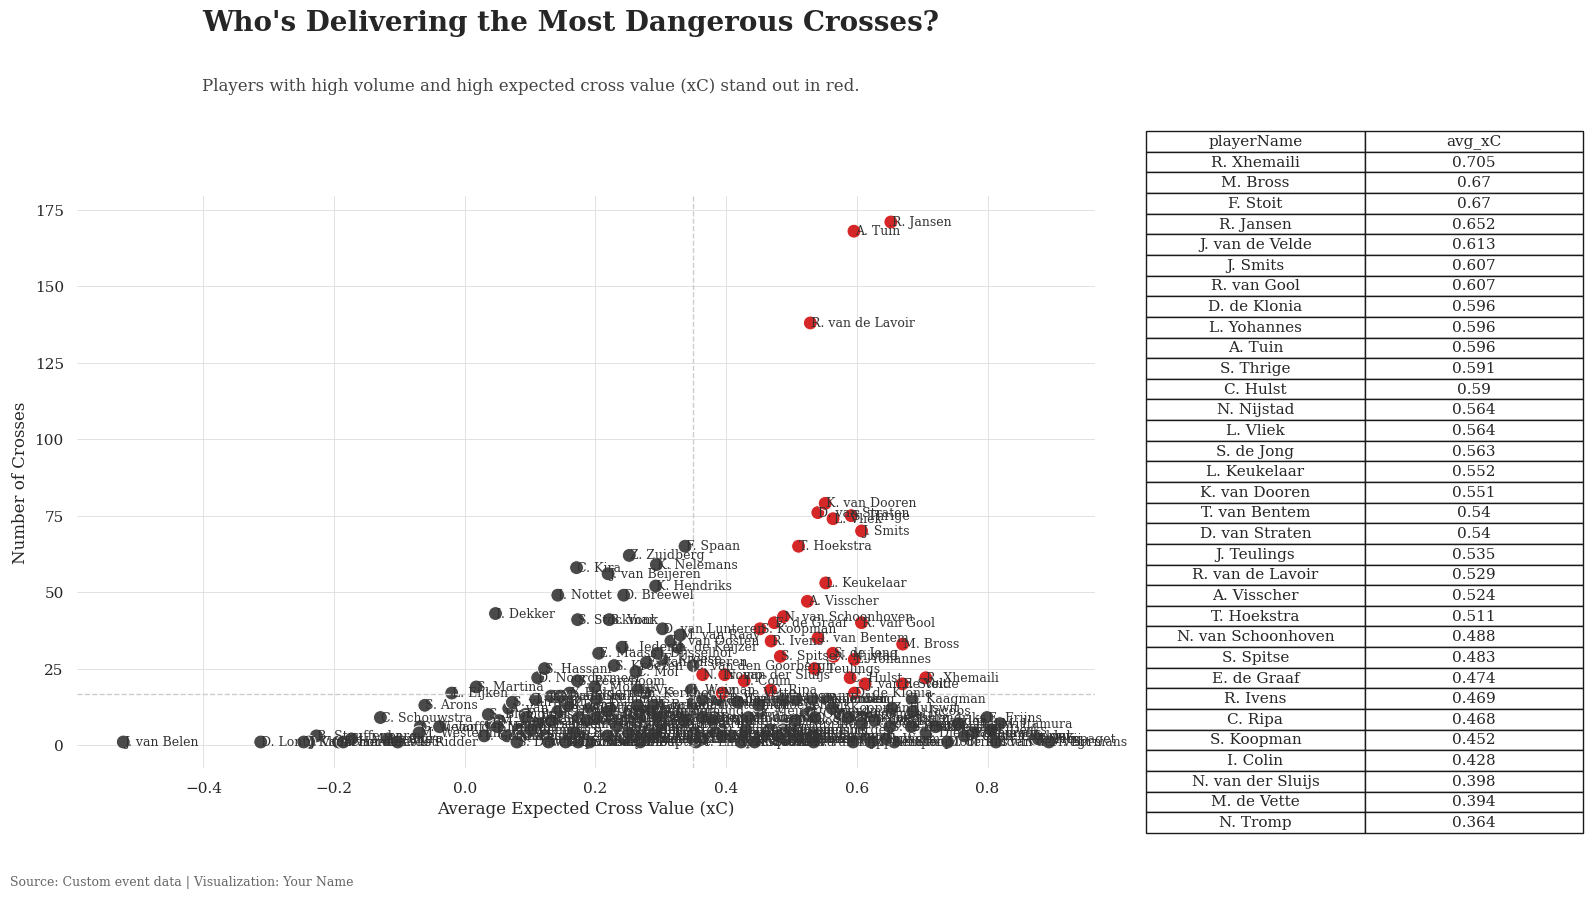

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate averages
mean_xC = summary['avg_xC'].mean()
mean_crosses = summary['num_crosses'].mean()

# Identify outliers
summary['is_outlier'] = (summary['avg_xC'] > mean_xC) & (summary['num_crosses'] > mean_crosses)
outliers = summary[summary['is_outlier']].sort_values(by='avg_xC', ascending=False)

# --- Layout ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9), gridspec_kw={'width_ratios': [2.8, 1]})
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'DejaVu Serif'

# --- Scatterplot (Left) ---
palette = {True: "#d62728", False: "#4a4a4a"}
sns.scatterplot(
    data=summary,
    x='avg_xC',
    y='num_crosses',
    hue='is_outlier',
    palette=palette,
    legend=False,
    s=100,
    edgecolor='white',
    linewidth=0.7,
    ax=ax1
)

# Add player name labels
for _, row in summary.iterrows():
    ax1.text(
        row['avg_xC'] + 0.001,
        row['num_crosses'],
        row['playerName'],
        fontsize=9,
        ha='left',
        va='center',
        color='#333333'
    )

# Average lines
ax1.axhline(mean_crosses, color='#cccccc', linestyle='--', linewidth=1)
ax1.axvline(mean_xC, color='#cccccc', linestyle='--', linewidth=1)

# Axis labels and style
ax1.set_xlabel("Average Expected Cross Value (xC)", fontsize=12)
ax1.set_ylabel("Number of Crosses", fontsize=12)
ax1.grid(color='#dddddd', linewidth=0.6)
sns.despine(left=True, bottom=True, ax=ax1)

# --- Title and Subtitle ---
fig.suptitle("Who's Delivering the Most Dangerous Crosses?", fontsize=20, weight='bold', x=0.13, ha='left')
fig.text(
    0.13, 0.89,
    "Players with high volume and high expected cross value (xC) stand out in red.",
    fontsize=12, ha='left', color='#444444'
)


# --- Table of Outliers (Right) ---
ax2.axis('off')
table_data = outliers[['playerName', 'avg_xC']].copy().round({'avg_xC': 3})

table = ax2.table(
    cellText=table_data.values,
    colLabels=table_data.columns,
    cellLoc='center',
    colLoc='center',
    loc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.5)

# --- Source Footer ---
fig.text(0.01, 0.01, "Source: Custom event data | Visualization: Your Name",
         ha='left', va='center', fontsize=9, color='#666666')

plt.tight_layout(rect=[0, 0.03, 1, 0.93])
plt.show()
